# Analyzing Similarity and Dissimilarity in Clothing

This project aims to build a model that would be able to tell the similarity and dissimilarity between two items of clothing.



The dataset used is the popular opened sourced Fashion Mnist data, featuring 10 classes of fashion items;

|Label|Description|
|---|---|
|0|T-Shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle Boot|



## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import random

## Data Preparation

This functions preprocess the data, creating pairs that will be compared for similarity and dissimilarity.

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

An example of a pair of images is shown below.

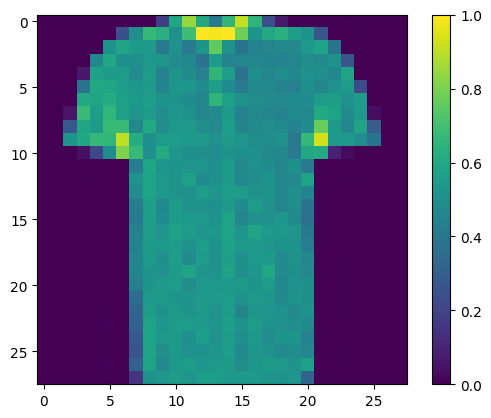

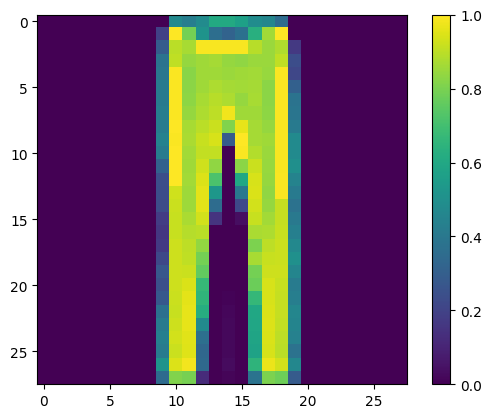

0.0


In [21]:
# array index
this_pair = 223

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

## Model Building.

In [8]:
def base_network(inputs):
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return x


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

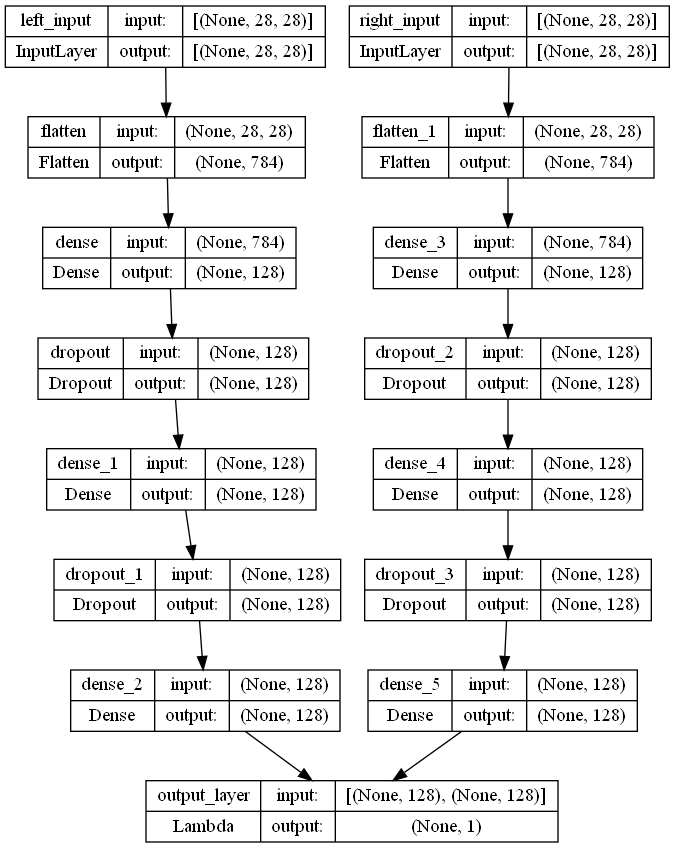

In [9]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28)]             0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['left_input[0][0]']          
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['right_input[0][0]']         
                                                                                            

## Model Training

Since the model compares the euclidean distance of the vector representation of two images, the contrastive loss function is used to compile the model.

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [12]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=RMSprop())


In [13]:
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20

938/938 [==============================] - 13s 11ms/step - loss: 0.1463 - val_loss: 0.1045
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0986 - val_loss: 0.0945
Epoch 3/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0891 - val_loss: 0.0923
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0834 - val_loss: 0.0821
Epoch 5/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0787 - val_loss: 0.0750
Epoch 6/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0752 - val_loss: 0.0733
Epoch 7/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0725 - val_loss: 0.0753
Epoch 8/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0708 - val_loss: 0.0734
Epoch 9/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0690 - val_loss: 0.0742
Epoch 10/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0677 - va

## Model Evaluation

In [14]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [15]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.06904313713312149, Train Accuracy = 0.926779463243874 Test Accuracy = 0.9076076076076076


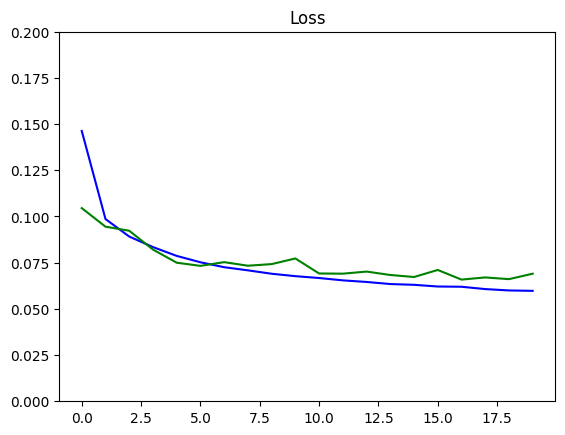

In [16]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)